# Tiny Character-level RNN Text Generator (PyTorch, GRU default)

**Goal:** Train a tiny character-level model to predict the next character given previous characters.

**Pipeline:** Embedding → RNN (Vanilla RNN / GRU / LSTM) → Linear → Softmax over characters  
**Training:** Teacher forcing, Cross-Entropy Loss, Adam Optimizer

This notebook includes:
- A tiny **toy corpus** for quick tests.
- Either **auto-download** a small public-domain text (e.g., *Pride and Prejudice* excerpt) **or upload your own `.txt`**.
- Switchable RNN type: `"gru"` (default), `"lstm"`, or `"rnn"`.
- Training & validation **loss curves**.
- Temperature-controlled **sampling** (τ = 0.7, 1.0, 1.2).
- A short **reflection** cell.


In [2]:

#@title Setup: imports and device
import math, os, io, sys, random, textwrap, time, urllib.request
from typing import List, Tuple

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

# Reproducibility
SEED = 1337
random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

In [3]:

#@title Configuration (feel free to tweak)
model_type = "gru"  #@param ["gru", "lstm", "rnn"] {allow-input: true}
embed_size = 128    #@param {type:"integer"}
hidden_size = 128   #@param {type:"integer"}
num_layers = 1      #@param {type:"integer"}
dropout = 0.0       #@param {type:"number"}

block_size = 100    #@param {type:"integer"}  # sequence length (50–100 suggested)
batch_size = 64     #@param {type:"integer"}
epochs = 10         #@param {type:"integer"}

learning_rate = 1e-3  #@param {type:"number"}

# Sampling
sample_start = "The "  #@param {type:"string"}
gen_length = 300       #@param {type:"integer"}  # 200–400 suggested
temperatures = [0.7, 1.0, 1.2]  #@param

print(f"Using device: {device}")
print(f"Model: {model_type}, hidden={hidden_size}, layers={num_layers}")


Using device: cpu
Model: gru, hidden=128, layers=1


## Data: choose one path
- **Toy text** (quick smoke test).
- **Auto-download** a ~100–200 KB excerpt from a public-domain novel (requires internet).
- **Upload your own `.txt`** (works in Colab/Jupyter).

> You can run multiple cells below and switch which `text_source` you pass into the preprocessing cell.

In [5]:

#@title Option A: Tiny Toy Text (no internet needed)
toy_text = """hello help helium hero
hello helper helpful hello
helium helps heroes hello
"""
print(toy_text[:200])


hello help helium hero
hello helper helpful hello
helium helps heroes hello



In [6]:

#@title Option B: Auto-download a small public-domain excerpt (requires internet)
# We'll attempt to download an excerpt of Pride and Prejudice (public domain).
# If internet is blocked, this will fail gracefully and you can upload instead.

download_text = ""
try:
    url = "https://www.gutenberg.org/cache/epub/1342/pg1342.txt"  # Pride and Prejudice
    with urllib.request.urlopen(url, timeout=20) as resp:
        raw = resp.read().decode("utf-8", errors="ignore")
    # Keep a slice (~150 KB) to stay small and quick to train
    download_text = raw[:160_000]
    print("Downloaded text length:", len(download_text))
    print(download_text[:500])
except Exception as e:
    print("Download failed:", e)
    print("You can use the toy text or upload your own in the next cell.")


Downloaded text length: 160000
﻿The Project Gutenberg eBook of Pride and Prejudice
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this


In [7]:

#@title Option C: Upload a .txt file (Colab: click the file chooser)
# If you're in Google Colab, this will prompt a file chooser.
# In Jupyter, you can place a file in the working dir and set upload_text_path to it.

upload_text = ""
upload_text_path = ""  #@param {type:"string"}
try:
    # Colab helper (ignored if not present)
    from google.colab import files  # type: ignore
    print("Colab detected. Use the chooser dialog to upload a .txt file (cancel to skip).")
    uploaded = files.upload()  # opens dialog
    if uploaded:
        fname = list(uploaded.keys())[0]
        upload_text = uploaded[fname].decode("utf-8", errors="ignore")
        print("Uploaded:", fname, "| length:", len(upload_text))
except Exception as _:
    # Fallback: read from a path if user set it
    if upload_text_path and os.path.exists(upload_text_path):
        with open(upload_text_path, "r", encoding="utf-8", errors="ignore") as f:
            upload_text = f.read()
        print("Read from path:", upload_text_path, "| length:", len(upload_text))
    else:
        print("No upload used. Set `upload_text_path` or run in Colab to choose a file.")


No upload used. Set `upload_text_path` or run in Colab to choose a file.


In [8]:

#@title Preprocess: choose which text source to use and build vocabulary
# Choose one of: toy_text, download_text, upload_text
text_source = "download_text"  #@param ["toy_text", "download_text", "upload_text"] {allow-input: true}

text = globals().get(text_source, "")
if not text:
    raise ValueError(f"Selected source '{text_source}' is empty. Try another source or re-run the earlier cells.")

# Normalize newlines; keep characters as-is otherwise for a char-level model
text = text.replace("\r\n", "\n").replace("\r", "\n")

# Train/val split
split = int(0.9 * len(text))
train_text = text[:split]
val_text = text[split:]

# Build vocabulary
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}

def encode(s: str):
    return [stoi[c] for c in s]

def decode(ix: list):
    return ''.join(itos[i] for i in ix)

print("Vocab size:", vocab_size)
print("Sample vocab:", chars[:100])


Vocab size: 91
Sample vocab: ['\n', ' ', '!', '#', '&', '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', '[', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', '·', 'à', 'â', 'é', 'ê', '‘', '’', '“', '”', '\ufeff']


In [9]:

#@title Dataset & DataLoaders (teacher forcing via shifted targets)
import torch.utils.data as tud

class CharDataset(tud.Dataset):
    def __init__(self, data_str: str, block_size: int):
        self.data = torch.tensor(encode(data_str), dtype=torch.long)
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size - 1

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + 1 + self.block_size]  # shift by one (teacher forcing)
        return x, y

train_ds = CharDataset(train_text, block_size)
val_ds   = CharDataset(val_text, block_size)

train_loader = tud.DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader   = tud.DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=True)

len(train_ds), len(val_ds)


(140879, 15564)

In [10]:

#@title Model: Embedding → (RNN/GRU/LSTM) → Linear
class CharModel(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=128, model_type="gru", num_layers=1, dropout=0.0):
        super().__init__()
        self.model_type = model_type.lower()
        self.embed = nn.Embedding(vocab_size, embed_size)
        if self.model_type == "gru":
            self.rnn = nn.GRU(embed_size, hidden_size, num_layers=num_layers, dropout=dropout if num_layers>1 else 0.0, batch_first=True)
        elif self.model_type == "lstm":
            self.rnn = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, dropout=dropout if num_layers>1 else 0.0, batch_first=True)
        elif self.model_type == "rnn":
            self.rnn = nn.RNN(embed_size, hidden_size, nonlinearity="tanh", num_layers=num_layers, dropout=dropout if num_layers>1 else 0.0, batch_first=True)
        else:
            raise ValueError("model_type must be 'gru', 'lstm', or 'rnn'")
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embed(x)  # (B, T, E)
        out, hidden = self.rnn(x, hidden)  # (B, T, H)
        logits = self.fc(out)  # (B, T, V)
        return logits, hidden

model = CharModel(vocab_size, embed_size, hidden_size, model_type, num_layers, dropout).to(device)
sum(p.numel() for p in model.parameters()), model


(122459,
 CharModel(
   (embed): Embedding(91, 128)
   (rnn): GRU(128, 128, batch_first=True)
   (fc): Linear(in_features=128, out_features=91, bias=True)
 ))

In [11]:

#@title Train
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

def run_epoch(loader, train_mode=True):
    total_loss = 0.0
    total_tokens = 0
    if train_mode:
        model.train()
    else:
        model.eval()

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        if train_mode:
            optimizer.zero_grad()

        logits, _ = model(x)
        # reshape for CE loss
        loss = criterion(logits.reshape(-1, logits.size(-1)), y.reshape(-1))

        if train_mode:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.numel()
        total_tokens += x.numel()

    return total_loss / max(total_tokens, 1)

for epoch in range(1, epochs + 1):
    tr_loss = run_epoch(train_loader, train_mode=True)
    va_loss = run_epoch(val_loader, train_mode=False)
    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    print(f"Epoch {epoch:02d} | train CE: {tr_loss:.4f} | val CE: {va_loss:.4f}")


Epoch 01 | train CE: 1.4913 | val CE: 1.5146
Epoch 02 | train CE: 1.1069 | val CE: 1.5874
Epoch 03 | train CE: 1.0227 | val CE: 1.6580
Epoch 04 | train CE: 0.9857 | val CE: 1.7015
Epoch 05 | train CE: 0.9641 | val CE: 1.7365
Epoch 06 | train CE: 0.9509 | val CE: 1.7558
Epoch 07 | train CE: 0.9396 | val CE: 1.7802
Epoch 08 | train CE: 0.9318 | val CE: 1.7970
Epoch 09 | train CE: 0.9261 | val CE: 1.8036
Epoch 10 | train CE: 0.9196 | val CE: 1.8288


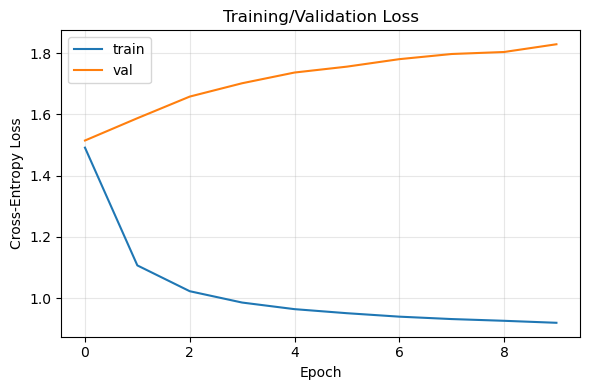

In [12]:

#@title Plot training & validation loss
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training/Validation Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [13]:

#@title Sampling (temperature)
import torch.nn.functional as F
import random

@torch.no_grad()
def sample(model, start_text="The ", length=300, temperature=1.0):
    model.eval()
    if not start_text:
        start_text = random.choice(chars)
    input_ids = torch.tensor([encode(start_text)], dtype=torch.long, device=device)
    hidden = None
    generated = list(start_text)

    for _ in range(length):
        logits, hidden = model(input_ids, hidden)
        last_logits = logits[:, -1, :] / max(1e-6, temperature)
        probs = F.softmax(last_logits, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1)  # sample
        next_char = itos[next_id.item()]
        generated.append(next_char)
        input_ids = next_id  # feed the sampled char

    return ''.join(generated)

for t in temperatures:
    print("\n" + "="*20 + f" Temperature {t} " + "="*20)
    print(sample(model, start_text=sample_start, length=gen_length, temperature=t))



==================== Temperature 0.7 ====================
The world, neglect my own they were not aloust was conversation with a resolvens, I will not more than he may down by his own colongley was once of
their justice: between him as a such great defer in their manners which in the tallest of his will be who, the others, and Mrs. Hurst were impossible of the

==================== Temperature 1.0 ====================
The impossible case. “I know; for Jane Bennet having going--a lively! I wish your elding after
persour-in plours, and of dancing is a meantian chation, only mayriblity to continues for whom he make always wish you was glaciy, to remance half eyes which what round
or proceed, therefore our friendshing or

==================== Temperature 1.2 ====================
The dealt are the only to capce _thosare.
But very good breaw, so: _has_ I am,” replied Darcy. “I do not pidetened
inervear gustent
his sister in_                                  eV.

“We gentleman from Lizzyed, 

## Reflection

- **Sequence length:** Longer `block_size` lets the model capture longer dependencies but can make optimization harder and slower; with small data it can overfit/repeat.
- **Hidden size:** Larger `hidden_size` increases capacity and can improve fluency, but may overfit on small corpora and train slower (more parameters).
- **Temperature:** Lower τ (e.g., 0.7) yields safer, more repetitive text; higher τ (e.g., 1.2) increases diversity but can become incoherent.
- **Teacher forcing:** Stabilizes training by using ground-truth previous chars, but at inference the model must cope without them (train–test mismatch).

## Connection to Slides

While working on this assignment, I noticed how closely it connects to the ideas from our **RNN and LSTM** lecture slides.

- **Embedding:**  
  Just like mentioned in the slides, the embedding layer turns one-hot encoded characters into dense vectors that carry more information.  
  In my model, the `nn.Embedding` layer does this automatically, helping the RNN learn character relationships instead of treating each one as completely independent.

- **Sampling Loop:**  
  The sampling loop in my notebook follows the same logic shown in the "Character-level language model" example from class.  
  During generation, the model predicts one character at a time and then feeds that prediction back in to generate the next.  
  It's cool to see how this loop gradually builds up coherent text from random noise at the start.

- **Teacher Forcing:**  
  I used teacher forcing during training — meaning the model always gets the true previous character instead of its own guess.  
  This was emphasized in the slides because it helps the model train faster and prevents early prediction errors from snowballing.  
  However, at inference time, the model has to rely on its own predictions, which makes generation more challenging but realistic.

- **Trade-offs (RNN vs GRU vs LSTM):**  
  The slides explained that vanilla RNNs struggle with long-term dependencies, while LSTMs handle them better with gating mechanisms.  
  GRUs are a simpler version that still perform well but train faster.  
  I chose **GRU** for this notebook since it strikes a good balance between complexity and efficiency for a small dataset.

- **Extra note (Transformers):**  
  From the later Transformer slides, I also see how attention models remove the need for recurrence entirely.  
  GRUs work well for short text, but Transformers can look at all positions at once and capture much longer relationships.  
